# What do consumers value in a used car?

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

**Background**: Used car dealerships purchase pre-owned vehicles at a price based on the vehicle's features and re-sell the vehicle for a profit. Dealerships are looking to maximze thei inventory with valuable vehicles

**Business Objectives**: Understand what factors make a vehivle more or less expensive. Provide reccomendations to client on what features of vehicles to focus on.

**Business Success Criteria**: Identification of features that influence the price of a car.

**Data Problem Definition**: Build a model to predict the price of a vehicle based on the factors provided in the dataset. Determine what factors influence this model the most.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [127]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error 
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.inspection import permutation_importance

# Suppress warnings
warnings.filterwarnings('ignore')


In [128]:
# Import dataset
df = pd.read_csv('data/vehicles.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [129]:
# Shape of dataset
df.shape

(426880, 18)

id               0.000000
region           0.000000
price            0.000000
year             0.282281
manufacturer     4.133714
model            1.236179
condition       40.785232
cylinders       41.622470
fuel             0.705819
odometer         1.030735
title_status     1.930753
transmission     0.598763
VIN             37.725356
drive           30.586347
size            71.767476
type            21.752717
paint_color     30.501078
state            0.000000
dtype: float64


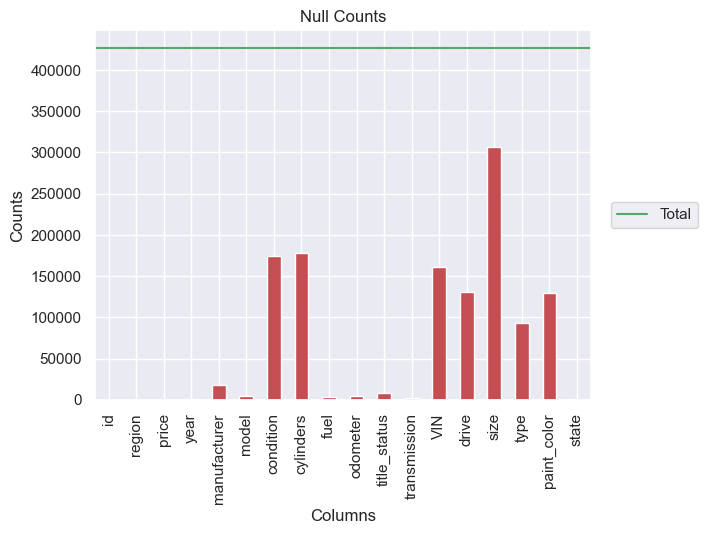

In [130]:
# Visualize null values in dataset

df.isnull().sum().plot(kind='bar', color='r')
plt.axhline(y=df.shape[0], color='g', linestyle='-', label='Total')
plt.title('Null Counts')
plt.xlabel('Columns')
plt.ylabel('Counts')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)

print(df.isnull().sum() / df.shape[0] * 100)

The data contains null values. Some columns more than others. Size is missing 71% of its values. Our target variable, price, is present for all rows. WIll be droping column missing a majority of its data as it will not be usefull for modeling.

In [131]:
# Examine numeric data
df.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


Price ranges from $0 to $3,736,928,711. That seems a bit ridiculous. Will be triming the dataset of outliers.

Year ranges from 1900 to 2022. It is currently a float.

Price and odometer will need to be normalized. 

When purchasing a car, you want to consider how old the car is. We can compute this with year.

In [132]:
# Examine catagorical data
for column in df.select_dtypes(exclude='number').columns:
    print(f'-----------{column}-----------')
    print(df[[column]].value_counts(normalize=True, dropna=False))
    print('-------------------------------')

-----------region-----------
region                 
columbus                   0.008452
jacksonville               0.008344
spokane / coeur d'alene    0.007000
eugene                     0.006993
fresno / madera            0.006988
                             ...   
meridian                   0.000066
southwest MS               0.000033
kansas city                0.000026
fort smith, AR             0.000021
west virginia (old)        0.000019
Length: 404, dtype: float64
-------------------------------
-----------manufacturer-----------
manufacturer   
ford               0.166288
chevrolet          0.128992
toyota             0.080121
honda              0.049824
nissan             0.044666
jeep               0.044542
ram                0.042968
NaN                0.041337
gmc                0.039320
bmw                0.034434
dodge              0.032110
mercedes-benz      0.027682
hyundai            0.024218
subaru             0.022243
volkswagen         0.021891
kia                0

In [133]:
# Discovery
df.query('fuel == "electric" and manufacturer == "tesla"')[['cylinders']].value_counts(dropna=False)

cylinders  
NaN            632
other           60
4 cylinders      5
6 cylinders      2
dtype: int64

In [134]:
# Find all vehicles that have electric fuel type and also cylinders
df.query('fuel == "electric"').dropna(subset=['cylinders'])

# Having spot checked a few of these on the internet via a VIN check online (https://vpic.nhtsa.dot.gov/decoder/Decoder) 
# and the fuel data does not match the VIN data (1GYS3DKJ9GR322052). This is not an electic vehicle.

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
5890,7312984797,anchorage / mat-su,63995,2017.0,tesla,model s 100d awd,excellent,4 cylinders,electric,32740.0,clean,automatic,5YJSA1E25HF204392,4wd,NaN,sedan,blue,ak
7092,7306965211,anchorage / mat-su,63995,2017.0,tesla,model s 100d awd,excellent,4 cylinders,electric,32740.0,clean,automatic,5YJSA1E25HF204392,4wd,NaN,sedan,blue,ak
7629,7302900513,anchorage / mat-su,54000,2018.0,tesla,s,excellent,other,electric,16000.0,clean,automatic,NaN,4wd,full-size,sedan,white,ak
8391,7315522870,southeast alaska,6999,2012.0,nissan,leaf,good,other,electric,62102.0,clean,automatic,NaN,fwd,compact,hatchback,black,ak
8455,7301681997,southeast alaska,24995,2019.0,nissan,leaf sl,like new,other,electric,5650.0,clean,automatic,1N4AZ1CP6KC307995,fwd,NaN,other,white,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420220,7314438407,madison,36995,2015.0,tesla,model s,good,other,electric,62560.0,clean,automatic,5YJSA1S26FF097869,4wd,NaN,hatchback,blue,wi
420346,7313900574,madison,43470,2018.0,volvo,s90,excellent,4 cylinders,electric,39149.0,clean,automatic,LVYBR0AL5JP048053,4wd,NaN,sedan,white,wi
421083,7308458462,madison,6999,2013.0,nissan,leaf sv,good,other,electric,60038.0,clean,automatic,NaN,fwd,NaN,NaN,NaN,wi
421666,7304202185,madison,9500,2016.0,ford,focus electric hatchback 4d,excellent,other,electric,20000.0,clean,other,NaN,fwd,compact,hatchback,white,wi


I know teslas are 100% electric, however the data is implying that teslas contain an internal combustion engine. This is false.
Additionally, doing some spot VIN checks on the data, I have found the data to be inaccurate.


In [135]:
# Discovery
df.query('fuel == "electric" and manufacturer == "tesla"')[['cylinders']].value_counts(dropna=False)

cylinders  
NaN            632
other           60
4 cylinders      5
6 cylinders      2
dtype: int64

With the above, the data leads me to believe its a bit unreliable. 

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [136]:
df_clean = df[[
    # Commenting out id
    # 'id', 
    'region',       # nominal
    'price',        # numeric
    'year',         # numeric
    'manufacturer', # nominal
    'model',        # nominal
    'condition',    # ordinal
    'cylinders',    # nominal
    'fuel',         # nominal
    'odometer',     # numeric
    'title_status', # ordinal
    'transmission', # nominal
    'VIN',          # nominal
    'drive',        # nominal
    'size',         # nominal
    'type',         # nominal
    'paint_color',  # nominal
    'state'         # nominal
    ]].copy()

In [137]:
# 71% of size is missing
df_clean.drop('size', axis=1, inplace=True)

# Drop all rows containing a null value
df_clean.dropna(inplace=True)

# Drop Duplicates
df_clean.drop_duplicates(inplace=True)

# Create age of car
df_clean['year'] = df_clean['year'].astype(int)
df_clean['age'] = 2023 - df_clean['year']

# Price of 0 is pointless to consider
df_clean = df_clean[df_clean['price'] != 0]


In [138]:
# Will use label encoding initially as one-hot encoding will be very expensive for the number of "catagories" in some columns
df_labeled = df_clean.copy()
for column in df_labeled.select_dtypes(exclude='number'):
    df_labeled[column] = LabelEncoder().fit_transform(df_labeled[column])

<Axes: >

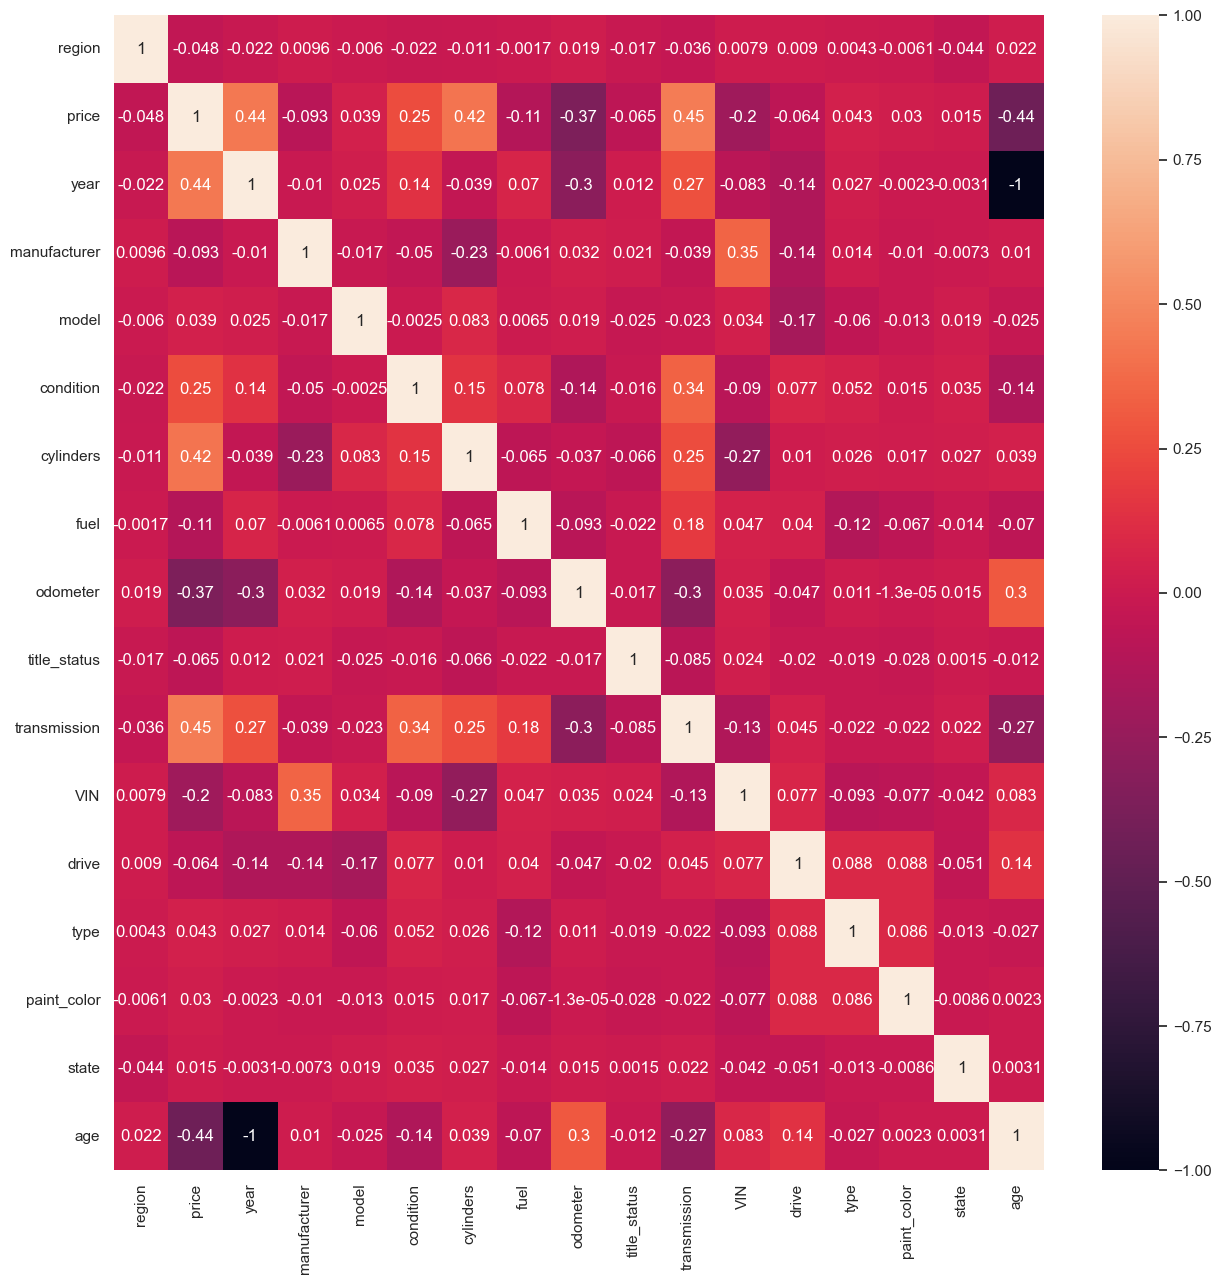

In [139]:
# Correlation matrix
df_labeled.corr()
plt.figure(figsize=(15,15))
sns.heatmap(df_labeled.corr(), annot=True)

Seems transmission and cylinders have the highest correlation with price.

Age and Odometer have the most negative correlation with price, which makes sense. As car gets older and used more, price decreases.

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [140]:
# Split test and train datasets
target = 'price'
X = df_labeled.drop(target, axis=1)
y = df_labeled[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=32)

In [141]:
# Use the average price as a baseline
test_baseline = mean_squared_error(y_test, np.full(len(y_test), y_test.mean()))
train_baseline = mean_squared_error(y_train, np.full(len(y_train), y_train.mean()))
print(f"Baseline Test Mean Squared Error: {test_baseline}")
print(f"Baseline Train Mean Squared Error: {train_baseline}")

Baseline Test Mean Squared Error: 195370417.38849205
Baseline Train Mean Squared Error: 185066750.53091338


### Feature Selection

Linear Test Mean Squared Error: 94256793.84335193
Linear Train Mean Squared Error: 93363981.33315311


Ridge Test Mean Squared Error: 94257027.10580419
Ridge Train Mean Squared Error: 93363981.36376384
Lasso Test Mean Squared Error: 94260960.50728366
Lasso Train Mean Squared Error: 93363994.2165227


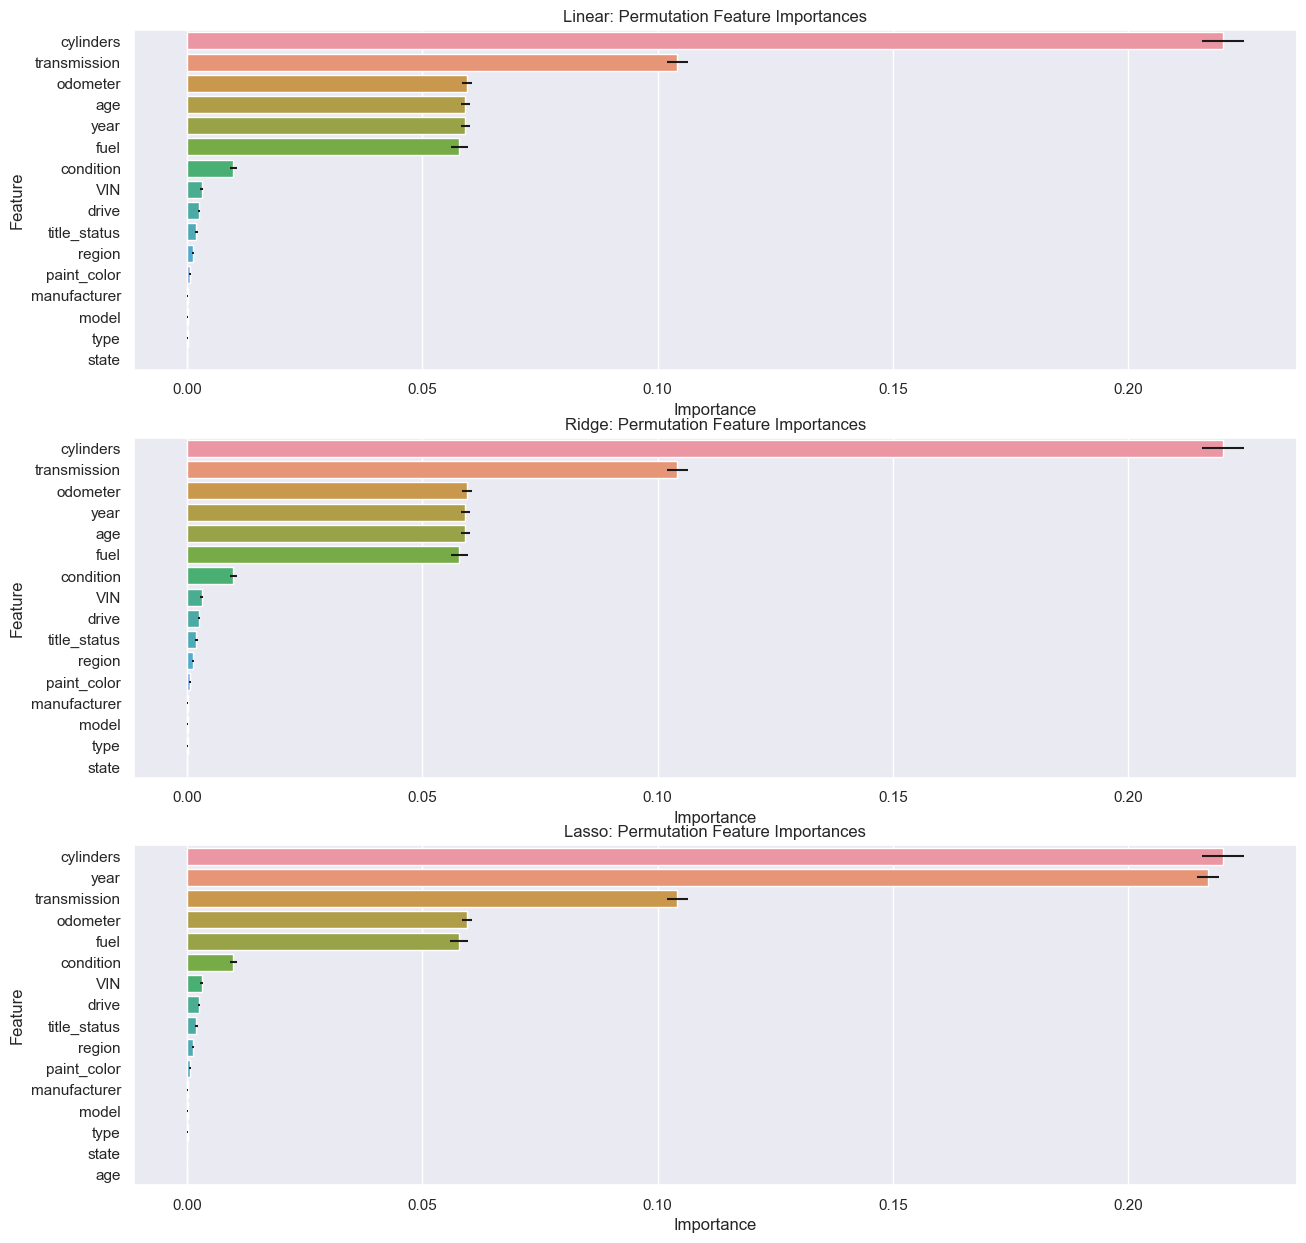

In [142]:
# Linear regression
# -----------------------------------------------------------
linear_pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('regressor', LinearRegression()) 
])

linear_pipeline.fit(X_train, y_train)

linear_y_test_pred = linear_pipeline.predict(X_test)
linear_y_train_pred = linear_pipeline.predict(X_train)

test_mse = mean_squared_error(y_test, linear_y_test_pred)
train_mse = mean_squared_error(y_train, linear_y_train_pred)
print(f"Linear Test Mean Squared Error: {test_mse}")
print(f"Linear Train Mean Squared Error: {train_mse}")


# Performing permutation feature importance
results = permutation_importance(linear_pipeline, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Get the importances and standard deviations
importances = results.importances_mean
std_devs = results.importances_std

# Create a DataFrame for feature importances
feature_names = X.columns
linear_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances, 'Std Dev': std_devs})

# Sorting the DataFrame
linear_importance_df = linear_importance_df.sort_values(by='Importance', ascending=False)

# Ridge Regression
# -----------------------------------------------------------
pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('regressor', Ridge()) 
])

pipeline.fit(X_train, y_train)

ridge_y_test_pred = pipeline.predict(X_test)
ridge_y_train_pred = pipeline.predict(X_train)

test_mse = mean_squared_error(y_test, ridge_y_test_pred)
train_mse = mean_squared_error(y_train, ridge_y_train_pred)
print(f"Ridge Test Mean Squared Error: {test_mse}")
print(f"Ridge Train Mean Squared Error: {train_mse}")


# Performing permutation feature importance
results = permutation_importance(pipeline, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Get the importances and standard deviations
importances = results.importances_mean
std_devs = results.importances_std

# Create a DataFrame for feature importances
feature_names = X.columns
ridge_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances, 'Std Dev': std_devs})

# Sorting the DataFrame
ridge_importance_df = ridge_importance_df.sort_values(by='Importance', ascending=False)

# Lasso Regression
# -----------------------------------------------------------
pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('regressor', Lasso()) 
])

pipeline.fit(X_train, y_train)

lasso_y_test_pred = pipeline.predict(X_test)
lasso_y_train_pred = pipeline.predict(X_train)

test_mse = mean_squared_error(y_test, lasso_y_test_pred)
train_mse = mean_squared_error(y_train, lasso_y_train_pred)
print(f"Lasso Test Mean Squared Error: {test_mse}")
print(f"Lasso Train Mean Squared Error: {train_mse}")


# Performing permutation feature importance
results = permutation_importance(pipeline, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Get the importances and standard deviations
importances = results.importances_mean
std_devs = results.importances_std

# Create a DataFrame for feature importances
feature_names = X.columns
lasso_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances, 'Std Dev': std_devs})

# Sorting the DataFrame
lasso_importance_df = lasso_importance_df.sort_values(by='Importance', ascending=False)


# Plotting 
# -----------------------------------------------------------

fig, axes = plt.subplots(3, 1, figsize=(15, 15))
ax1, ax2, ax3 = axes.flatten()

# Linear
sns.barplot(x='Importance', y='Feature', data=linear_importance_df, xerr=linear_importance_df['Std Dev'], ax=ax1)
ax1.set_title('Linear: Permutation Feature Importances')

# Ridge
sns.barplot(x='Importance', y='Feature', data=ridge_importance_df, xerr=ridge_importance_df['Std Dev'], ax=ax2)
ax2.set_title('Ridge: Permutation Feature Importances')

# Lasso
sns.barplot(x='Importance', y='Feature', data=lasso_importance_df, xerr=lasso_importance_df['Std Dev'], ax=ax3)
ax3.set_title('Lasso: Permutation Feature Importances')

# Show the plot
plt.show()




Using permutation importance from sklearn on both a linear, ridge and lasso models, all seem to identify 6 important features. I will take these features and build a model focusing on these.

In [143]:
df_model = df_clean[[
    # Target
    'price',        # numeric

    # Features
    'age',          # numeric
    'condition',    # ordinal
    'cylinders',    # nominal
    'fuel',         # nominal
    'odometer',     # numeric
    'transmission', # nominal
    
]].copy()

target = 'price'
X = df_model.drop(target, axis=1)
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=32)

### Polynomial Fitting

The Complexity that minimized Test Error was: 6
test errors:  [85634419.85888392, 65007957.44436001, 61211692.96386183, 60725680.27889978, 60686568.103637666, 60487384.58155314, 79244560.29535696, 3142694537.182351]


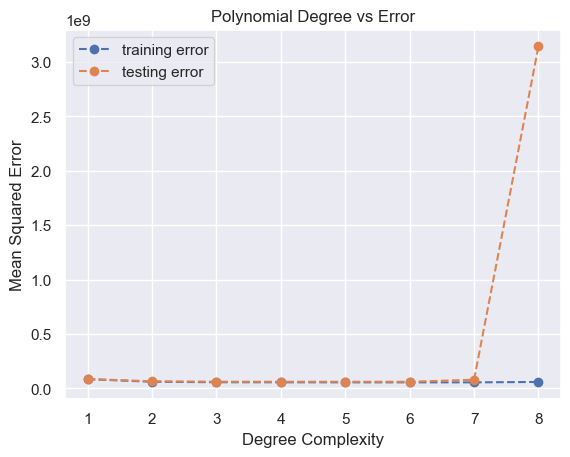

In [144]:
trainErrors = []
testErrors = []
    
for i in range(1, 9):

    # Define the columns
    numeric_features = ['age', 'odometer']
    ordinal_features = ['condition']
    nominal_features = ['cylinders', 'fuel', 'transmission']

    # Create transformers for each type of feature
    # Combine transformers into a ColumnTransformer
    
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=i, include_bias=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('numerical', numeric_transformer, numeric_features),
            ('ordinal', OrdinalEncoder(categories=[['fair', 'salvage', 'good', 'like new', 'new', 'excellent']]), ordinal_features),
            ('nominal', OneHotEncoder(handle_unknown='ignore'), nominal_features)
        ])

    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model_regression", LinearRegression())
    ])

    pipe.fit(X_train, y_train)

    trainErrors.append(mean_squared_error(pipe.predict(X_train), y_train))
    testErrors.append(mean_squared_error(pipe.predict(X_test), y_test))

print(f'The Complexity that minimized Test Error was: {testErrors.index(min(testErrors)) + 1}')
print("test errors: ", testErrors)
plt.plot(range(1, 9), trainErrors, '--o', label = 'training error')
plt.plot(range(1, 9), testErrors, '--o', label = 'testing error')
plt.xticks(range(1, 9), range(1, 9))
plt.title('Polynomial Degree vs Error')
plt.xlabel('Degree Complexity')
plt.ylabel('Mean Squared Error')
plt.legend()


### Linear Regression with Polynomial Deg 6

Linear + Poly Deg 6: Test Mean Squared Error 60487384.58155314
Linear + Poly Deg 6: Train Mean Squared Error 55085566.16629676


Text(0, 0.5, 'Predicted Price')

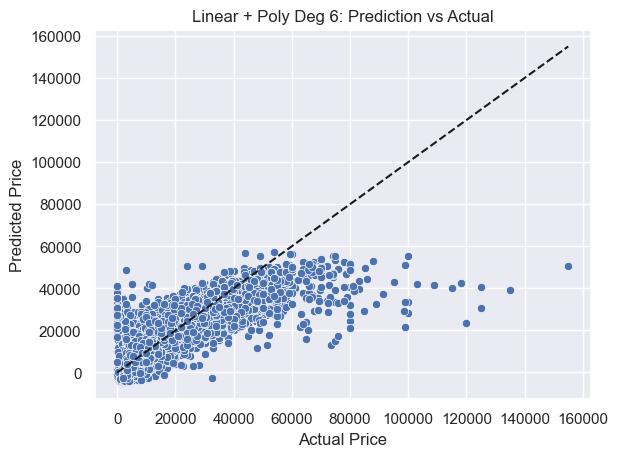

In [145]:
# Define the columns
numeric_features = ['age', 'odometer']
ordinal_features = ['condition']
nominal_features = ['cylinders', 'fuel', 'transmission']

# Create transformers for each type of feature
# Combine transformers into a ColumnTransformer

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=6, include_bias=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numeric_transformer, numeric_features),
        ('ordinal', OrdinalEncoder(categories=[['fair', 'salvage', 'good', 'like new', 'new', 'excellent']]), ordinal_features),
        ('nominal', OneHotEncoder(handle_unknown='ignore'), nominal_features)
    ])

linear_poly_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

linear_poly_pipe.fit(X_train, y_train)

poly_y_test_predict = linear_poly_pipe.predict(X_test)
poly_y_train_predict = linear_poly_pipe.predict(X_train)

test_mse = mean_squared_error(linear_poly_pipe.predict(X_test), y_test)
train_mse = mean_squared_error(linear_poly_pipe.predict(X_train), y_train)
print('Linear + Poly Deg 6: Test Mean Squared Error', test_mse)
print('Linear + Poly Deg 6: Train Mean Squared Error', train_mse)

sns.scatterplot(x=y_test, y=poly_y_test_predict)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--k')  # Diagonal line
plt.title('Linear + Poly Deg 6: Prediction vs Actual')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')

### Ridge Regression with Polynomial Degree 6

Ridge + Poly Deg 6: Test Mean Squared Error: 76243189.93829021
Ridge + Poly Deg 6: Train Mean Squared Error: 65597834.61321118


Text(0, 0.5, 'Predicted Price')

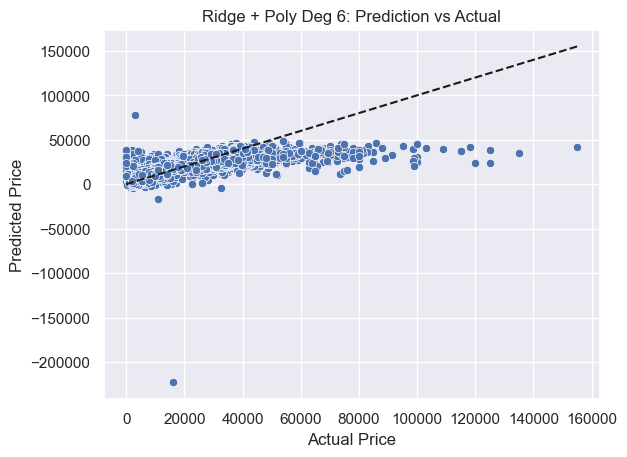

In [146]:
# Define the columns
numeric_features = ['age', 'odometer']
ordinal_features = ['condition']
nominal_features = ['cylinders', 'fuel', 'transmission']

# Create transformers for each type of feature
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=6, include_bias=False))
])

# Combine transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numeric_transformer, numeric_features),
        ('ordinal', OrdinalEncoder(categories=[['fair', 'salvage', 'good', 'like new', 'new', 'excellent']]), ordinal_features),
        ('nominal', OneHotEncoder(handle_unknown='ignore'), nominal_features)
    ])

ridge_poly_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", Ridge())
])

param_grid = {'regressor__alpha': np.logspace(-4, 4, 50)}
grid_search = GridSearchCV(ridge_poly_pipe, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
ridge_best_model = grid_search.best_estimator_

test_y_pred = ridge_best_model.predict(X_test)
train_y_pred = ridge_best_model.predict(X_train)
test_mse = mean_squared_error(y_test, test_y_pred)
train_mse = mean_squared_error(y_train, train_y_pred)
print(f"Ridge + Poly Deg 6: Test Mean Squared Error: {test_mse}")
print(f"Ridge + Poly Deg 6: Train Mean Squared Error: {train_mse}")

sns.scatterplot(x=y_test, y=test_y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--k')  # Diagonal line
plt.title('Ridge + Poly Deg 6: Prediction vs Actual')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')

### Lasso Regression with Polynomial Degree 6

Lasso + Poly Deg 6: Test Mean Squared Error: 95459175.47576755
Lasso + Poly Deg 6: Train Mean Squared Error: 87661196.14914484


Text(0, 0.5, 'Predicted Price')

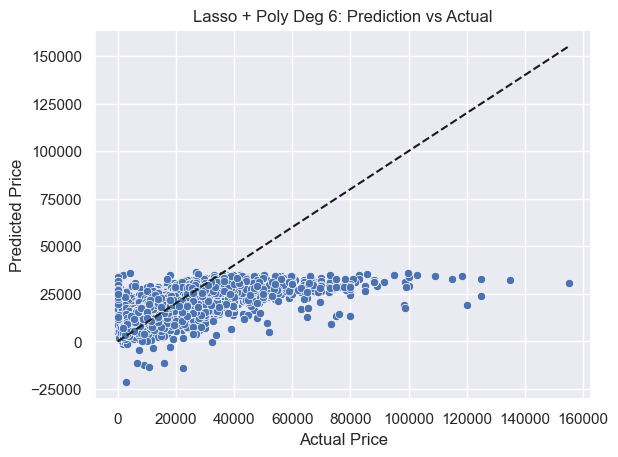

In [147]:
# Define the columns
numeric_features = ['age', 'odometer']
ordinal_features = ['condition']
nominal_features = ['cylinders', 'fuel', 'transmission']

# Create transformers for each type of feature
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=6, include_bias=False))
])

# Combine transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numeric_transformer, numeric_features),
        ('ordinal', OrdinalEncoder(categories=[['fair', 'salvage', 'good', 'like new', 'new', 'excellent']]), ordinal_features),
        ('nominal', OneHotEncoder(handle_unknown='ignore'), nominal_features)
    ])

lasso_poly_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", Lasso())
])

param_grid = {'regressor__alpha': np.logspace(-4, 4, 10)}
grid_search = GridSearchCV(lasso_poly_pipe, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
lasso_best_model = grid_search.best_estimator_

test_y_pred = lasso_best_model.predict(X_test)
train_y_pred = lasso_best_model.predict(X_train)
test_mse = mean_squared_error(y_test, test_y_pred)
train_mse = mean_squared_error(y_train, train_y_pred)
print(f"Lasso + Poly Deg 6: Test Mean Squared Error: {test_mse}")
print(f"Lasso + Poly Deg 6: Train Mean Squared Error: {train_mse}")


sns.scatterplot(x=y_test, y=test_y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--k')  # Diagonal line
plt.title('Lasso + Poly Deg 6: Prediction vs Actual')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

| Model     | Train Error (mse) | Test Error (mse) |
|-----------|-------------|------------|
| Baseline | 185066750 | 195370417|
| Linear + Poly Deg 6   | 55085566 | 60487384 |
| Ridge + Poly Deg 6   | 65597834 | 76243189 |
| Lasso + Poly Deg 6   | 87661196 | 95459175 |



### Cross Validation

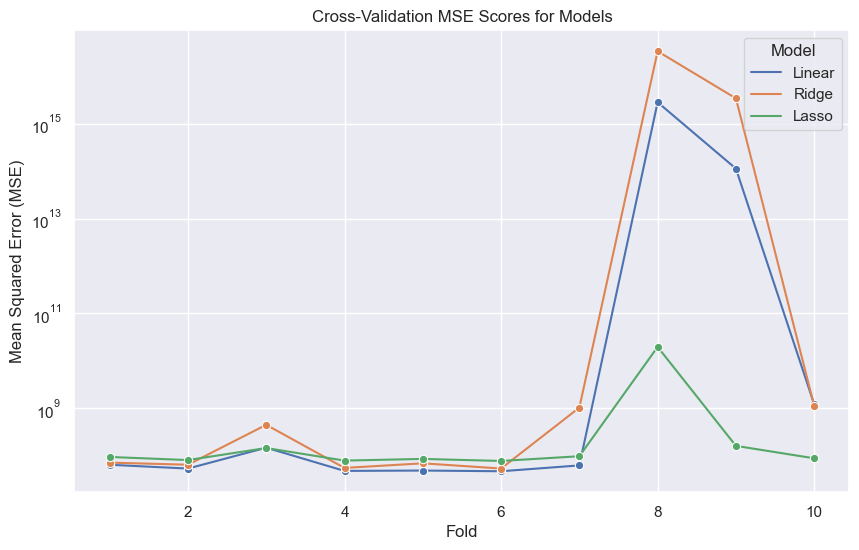

In [148]:
linear_poly_pipe_scores = cross_val_score(linear_poly_pipe, X, y, cv=10, scoring='neg_mean_squared_error')
ridge_poly_pipe_scores = cross_val_score(ridge_best_model, X, y, cv=10, scoring='neg_mean_squared_error')
lasso_poly_pipe_scores = cross_val_score(lasso_best_model, X, y, cv=10, scoring='neg_mean_squared_error')


# Convert to positive MSE for easier interpretation
linear = [-x for x in linear_poly_pipe_scores]
ridge = [-x for x in ridge_poly_pipe_scores]
lasso = [-x for x in lasso_poly_pipe_scores]

# Creating a DataFrame for plotting
data = {
    'Fold': list(range(1, 11)) * 3,
    'MSE': linear + ridge + lasso,
    'Model': ['Linear'] * 10 + ['Ridge'] * 10 + ['Lasso'] * 10
}

df = pd.DataFrame(data)

sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))

# Create the line plot
ax = sns.lineplot(data=df, x='Fold', y='MSE', hue='Model', marker='o')
ax.set_yscale('log')

plt.title('Cross-Validation MSE Scores for Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.xlabel('Fold')
plt.legend(title='Model')
plt.show()


During cross validation, the lasso model performs the best, having the smallest mse throughout 10 folds

Lasso model had the smallest cross validation scores, indicating it is better at predicting the price

discuss overfitting possibly

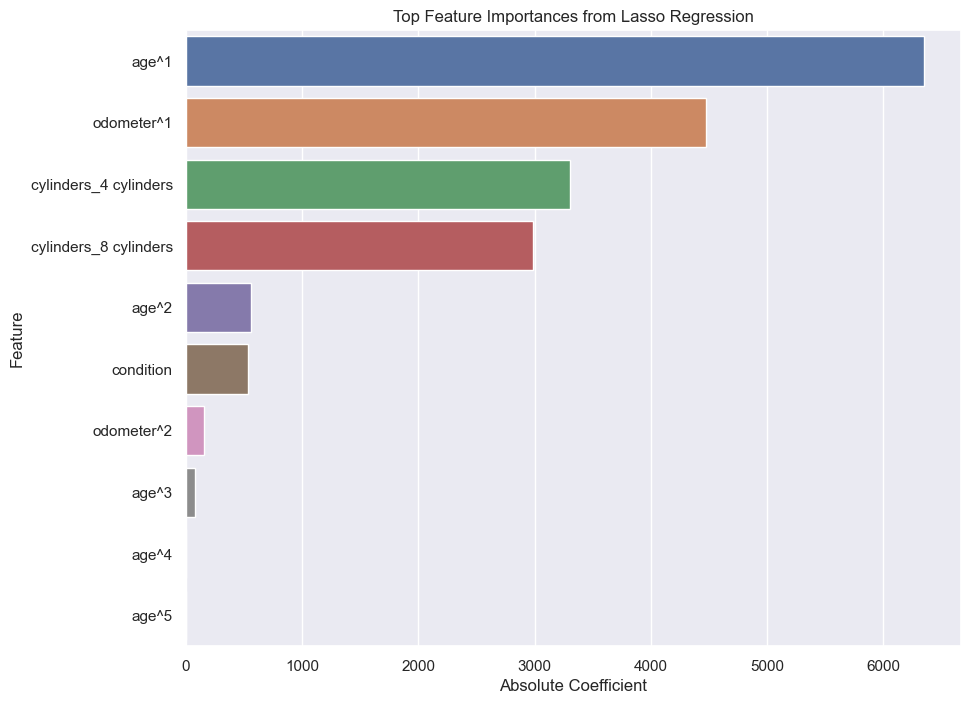

,Feature,Coefficient,abs_coefficient
0,age^1,-6353.507770,6353.507770
1,odometer^1,-4472.532749,4472.532749
31,cylinders_4 cylinders,-3303.661394,3303.661394
34,cylinders_8 cylinders,2983.768625,2983.768625
2,age^2,556.675508,556.675508
27,condition,-531.050991,531.050991
4,odometer^2,155.464769,155.464769
5,age^3,75.493690,75.493690
9,age^4,3.833512,3.833512
14,age^5,-1.467450,1.467450


In [149]:
best_model = lasso_best_model.named_steps['regressor']

poly_transformer = lasso_best_model.named_steps['preprocessor'].named_transformers_['numerical'].named_steps['poly']
original_numeric_features = numeric_features 
powers = poly_transformer.powers_

poly_feature_names = [' * '.join([f'{original_numeric_features[j]}^{i}' if i != 0 else '' 
                                  for j, i in enumerate(power) if i != 0]) 
                      for power in powers]
ordinal_feature_names = ordinal_features 
onehot_transformer = lasso_best_model.named_steps['preprocessor'].named_transformers_['nominal']

# Manually create feature names for one-hot encoded features
categories = onehot_transformer.categories_
categorical_features = [f'{nominal_features[i]}_{cat}' for i, cats in enumerate(categories) for cat in cats]


all_feature_names = poly_feature_names + ordinal_feature_names + list(categorical_features)
coefficients = best_model.coef_

feature_importance = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefficients
})
feature_importance['abs_coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='abs_coefficient', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(10), x='abs_coefficient', y='Feature', orient='h')
plt.title('Top Feature Importances from Lasso Regression')
plt.xlabel('Absolute Coefficient')
plt.ylabel('Feature')
plt.show()

feature_importance.head(10)

According to the model coefficients, age and price have an inverse relationship. This makes sense as vehicles get older, their price tends to decrease.
Similarly, odometer and price also have an inverse relationship since more miles on the vehicle tend to decrease the life left in the vehicle.

A 4 cylinder engine tended to devalue the vehicle as opposed to an 8 cylinder engine which tended to increase the value of the vehicle. 

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

Text(781.5909090909089, 0.5, 'Price')

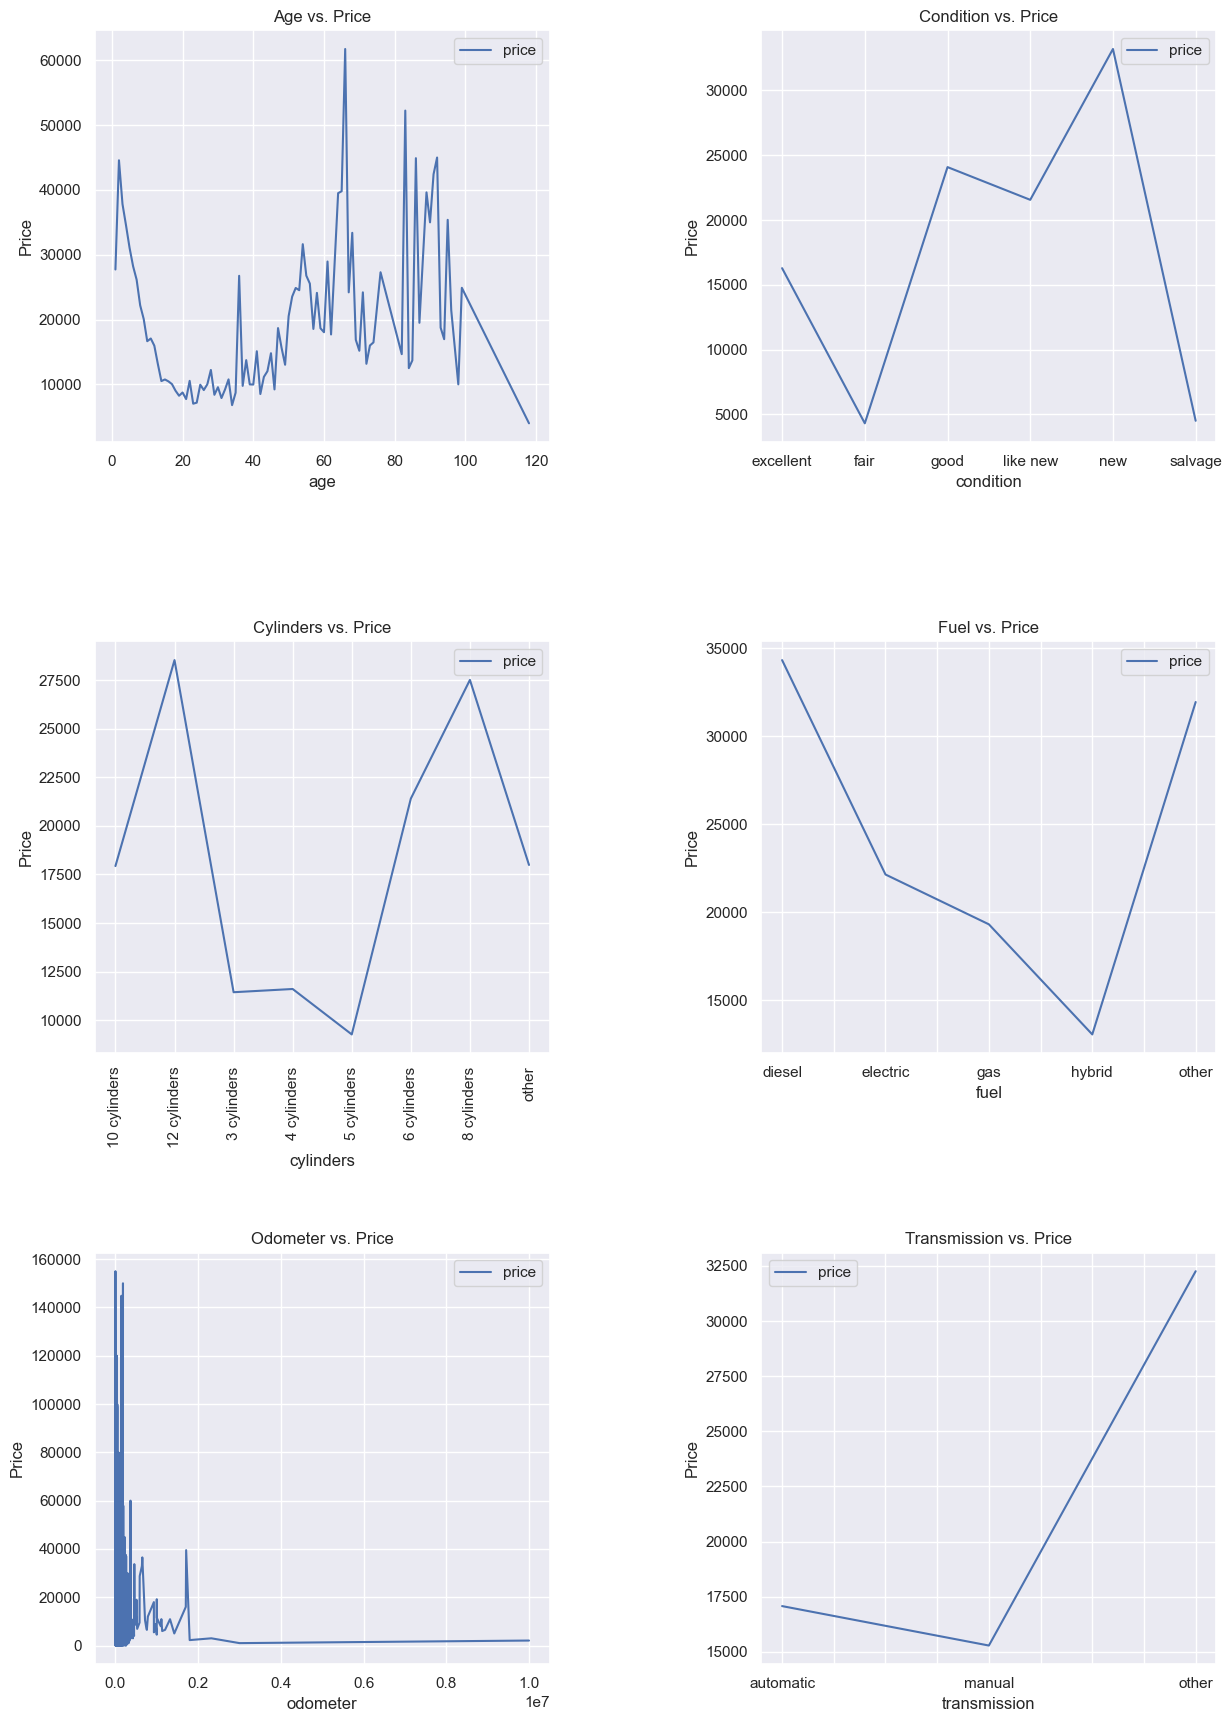

In [150]:
# Investigate the above features on the data against price
#     'age',          # numeric
#     'condition',    # ordinal
#     'cylinders',    # nominal
#     'fuel',         # nominal
#     'odometer',     # numeric
#     'transmission', # nominal

fig, axes = plt.subplots(3, 2, figsize=(15, 20))
fig.tight_layout(pad=10, w_pad=10, h_pad=10)
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

df_clean.groupby('age')[['price']].mean().plot(ax=ax1)
ax1.set_title('Age vs. Price')
ax1.set_ylabel('Price')
df_clean.groupby('condition')[['price']].mean().plot(ax=ax2)
ax2.set_title('Condition vs. Price')
ax2.set_ylabel('Price')
df_clean.groupby('cylinders')[['price']].mean().plot(ax=ax3)
ax3.set_title('Cylinders vs. Price')
ax3.set_ylabel('Price')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=90)
df_clean.groupby('fuel')[['price']].mean().plot(ax=ax4)
ax4.set_title('Fuel vs. Price')
ax4.set_ylabel('Price')
df_clean.groupby('odometer')[['price']].mean().plot(ax=ax5)
ax5.set_title('Odometer vs. Price')
ax5.set_ylabel('Price')
df_clean.groupby('transmission')[['price']].mean().plot(ax=ax6)
ax6.set_title('Transmission vs. Price')
ax6.set_ylabel('Price')

Text(0.5, 1.0, 'Value Held Over Time')

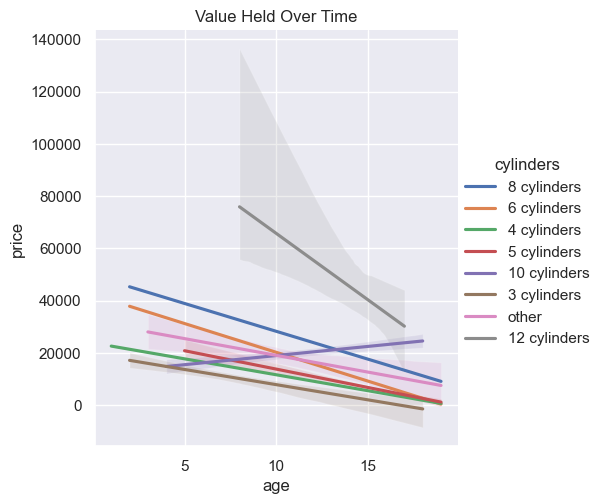

In [151]:
sns.lmplot(data=df_clean.query("age < 20"), x='age', y='price', hue='cylinders', scatter=False)
plt.title('Value Held Over Time')

In [79]:
df_clean.describe()

,price,year,odometer,age
count,51527.000000,51527.000000,5.152700e+04,51527.000000
mean,20472.299125,2012.268558,8.955432e+04,10.731442
std,13717.801582,6.842430,1.004132e+05,6.842430
min,1.000000,1905.000000,0.000000e+00,1.000000
25%,8990.000000,2010.000000,3.569750e+04,6.000000
50%,17500.000000,2014.000000,8.330900e+04,9.000000
75%,29995.000000,2017.000000,1.282530e+05,13.000000
max,155000.000000,2022.000000,9.999999e+06,118.000000
